# MNIST digit classification

In [3]:
%load_ext autoreload
%autoreload 2

In [1]:
%matplotlib inline

We'll train a simple CNN on the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset by copy/pasting [this example](https://keras.io/examples/mnist_cnn/) from the Keras documentation.

In [2]:
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Using TensorFlow backend.


4423680/4422102 [==============================] - 1s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 162s 3ms/step - loss: 0.5744 - acc: 0.7972 - val_loss: 0.3561 - val_acc: 0.8709
Epoch 2/12
60000/60000 [==============================] - 122s 2ms/step - loss: 0.3626 - acc: 0.8702 - val_loss: 0.3026 - val_acc: 0.8909
Epoch 3/12
60000/60000 [==============================] - 104s 2ms/step - loss: 0.3119 - acc: 0.8883 - val_loss: 0.2741 - val_acc: 0.8992
Epoch 4/12
60000/60000 [==============================] - 146s 2ms/step - loss: 0.2782 - acc: 0.8986 - val_loss: 0.2663 - val_acc: 0.9011
Epoch 5/12
60000/60000 [==============================] - 115s 2ms/step - loss: 0.2565 - acc: 0.9099 - val_loss: 0.2551 - val_acc: 0.9062
Epoch 6/12
60000/60000 [==============================] - 124s 2ms/step - loss: 0.2371 - acc: 0.9151 - val_loss: 0.2412 - va

Now let's predict the class probabilities for the test set.

In [13]:
import pandas as pd

columns = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

y_pred = model.predict_proba(x_test)
y_pred = pd.DataFrame(y_pred, columns=columns)

Run the algorithm.

In [28]:
import ethik

explainer = ethik.ImageExplainer(alpha=0.1, n_jobs=1)
%time explainer = explainer.fit(x_test)

CPU times: user 21.2 s, sys: 52.7 ms, total: 21.2 s
Wall time: 21.3 s


In [15]:
%time preds = explainer.explain_predictions(x_test, y_pred)

CPU times: user 76.5 ms, sys: 15.9 ms, total: 92.4 ms
Wall time: 9.24 s


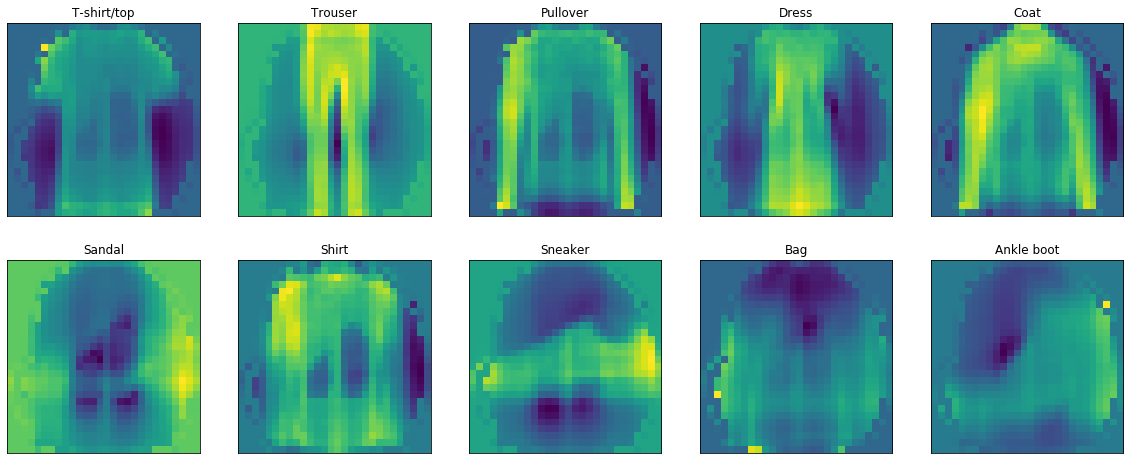

In [16]:
fig, axes = explainer.plot_predictions(x_test, y_pred, n_cols=5)

T-shirt vs. pullover.

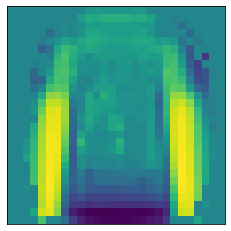

In [21]:
mask = (y_test[:, 0] == 1) | (y_test[:, 2] == 1)

ax = explainer.plot_predictions(x_test[mask], y_pred[mask]['Pullover'])

Sandal vs. sneaker.

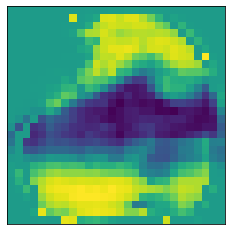

In [24]:
mask = (y_test[:, 5] == 1) | (y_test[:, 7] == 1)

ax = explainer.plot_predictions(x_test[mask], y_pred[mask]['Sandal'])